In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import linear_model as lm
from sklearn.cross_validation import cross_val_score
import seaborn as sns
from stop_words import get_stop_words
import Stemmer
import pymorphy2
from segtok import segmenter
import re
from functools import partial
import pickle
%matplotlib inline

In [155]:
data = pd.read_csv('data/comments.csv.gz')

In [156]:
data.shape

(180687, 6)

In [157]:
data.is_gum.value_counts()

1.0    90633
0.0    90054
Name: is_gum, dtype: int64

In [158]:
data.head(3)

,from_id,text,is_gum,hour,likes,sex
0,360037882,"[id352784000|Алексей], 2:1",0.0,18,1,2
1,360037882,НАТЯНУЛИ МОСКВиЧЕЙ!!! ТЕПЕРЬ МОЖНО И ДОМОЙ ИХ ...,0.0,18,35,2
2,360037882,"[id34736142|Андрей], не имеет значение где ЮР,...",0.0,10,0,2


### Length of comments (symbols)

In [159]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180687 entries, 0 to 180686
Data columns (total 6 columns):
from_id    180687 non-null int64
text       180687 non-null object
is_gum     180687 non-null float64
hour       180687 non-null int64
likes      180687 non-null int64
sex        180687 non-null int64
dtypes: float64(1), int64(4), object(1)
memory usage: 8.3+ MB


In [160]:
lenghts_symb = np.array([len(m) for m in data.text.values])

In [161]:
lenghts_symb.mean(), np.median(lenghts_symb)

(77.064913358459663, 47.0)

In [162]:
min(lenghts_symb), max(lenghts_symb)

(1, 9947)

In [163]:
sum(lenghts_symb)

13924628

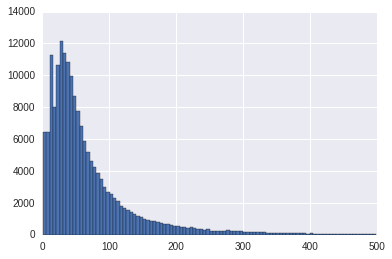

In [164]:
plt.hist(lenghts_symb[lenghts_symb < 500], bins=100);

In [165]:
print('{:.2f}% of comments are shorter than {} symbols'
      .format(lenghts_symb[lenghts_symb < 500].shape[0] / lenghts_symb.shape[0] * 100, 500))

99.04% of comments are shorter than 500 symbols


In [166]:
print('{:.2f}% of comments are longer than {} symbols'
      .format(lenghts_symb[lenghts_symb > 20].shape[0] / lenghts_symb.shape[0] * 100, 15))

82.19% of comments are longer than 15 symbols


### Length of comments (words)

In [167]:
lenghts_word = np.array([len(m.split()) for m in data.text.values])

In [168]:
lenghts_word.mean(), np.median(lenghts_word)

(11.438432205969439, 7.0)

In [169]:
min(lenghts_word), max(lenghts_word)

(1, 1612)

In [170]:
sum(lenghts_word)

2066776

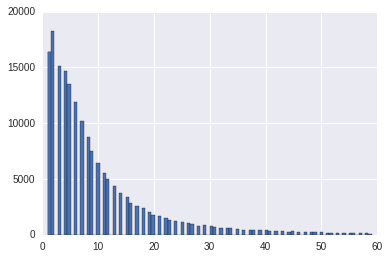

In [171]:
plt.hist(lenghts_word[lenghts_word < 60], bins=100);

In [172]:
print('{:.2f}% of comments are shorter than {} words'
      .format(lenghts_word[lenghts_word < 60].shape[0] / lenghts_word.shape[0] * 100, 60))

98.11% of comments are shorter than 60 words


In [173]:
print('{:.2f}% of comments are longer than {} words'
      .format(lenghts_word[lenghts_word > 4].shape[0] / lenghts_word.shape[0] * 100, 4))

64.34% of comments are longer than 4 words


### Links

In [174]:
links = [m for m in data.text.values if 'http' in m or 'www' in m or '.ru' in m or '.com' in m] 

In [175]:
links[:5]

['[id99906417|Илья], http://prostitutki-voronezha.info/',
 'Вот, как раз на эту тему http://s02.yapfiles.ru/files/531066/SHkala_masshtabov_Vselennoy_v.2.swf Про масштабы вселенной, админы проигнорили мой пост, видимо про котят интереснее.....',
 'Она каким то образом пишет в вк? Значит у нее есть доступ к 2gis.ru',
 'http://www.zakonrf.info/koap/20.1/',
 'http://m.youtube.com/#/watch?feature=youtu.be&v=yfDOcUSLZ6o&desktop_uri=%2Fwatch%3Fv%3DyfDOcUSLZ6o%26feature%3Dyoutu.be\nДоставило, особенно комментарии. Спасители наши']

In [176]:
print('{:.2f}% of comments contain links'.format(len(links) / len(data) * 100))

0.57% of comments contain links


## Preprocessing

### Dropping short and long

In [177]:
comments = data[(lenghts_word < 60) & (lenghts_word > 4)]

In [178]:
comments.shape

(112845, 6)

### Dropping with spam

In [179]:
without_link = [False if 'http' in c or 'www' in c or '.ru' in c or '.com' in c else True for c in comments.text.values] 

In [180]:
comments = comments[without_link]

In [181]:
comments.shape

(112262, 6)

In [182]:
comments_lenghts = np.array([len(m) for m in comments.text.values])

In [183]:
comments_lenghts.argsort()[:10]

array([ 7135, 10937, 60662, 11248, 11328, 60555, 11395, 47391, 56784, 11188])

In [184]:
comments.text.values[7135]

'😂 😂 😂 😂 😂'

In [185]:
comments.is_gum.value_counts()

0.0    57151
1.0    55111
Name: is_gum, dtype: int64

In [186]:
vectorizer = CountVectorizer(max_features=1000, ngram_range=(3, 3), analyzer='char_wb', min_df=100)
X = vectorizer.fit_transform(comments.text.values)
y = comments.is_gum.values

In [ ]:
X.shape

In [ ]:
lr = lm.LogisticRegression()

In [118]:
np.random.seed(0)

In [120]:
baseline_scores = cross_val_score(lr, X, y, cv=5)
baseline_scores.mean(), baseline_scores.std()

(0.51701813088475601, 0.011140770271970973)

In [121]:
lr.fit(X, y)
lr.score(X, y)

0.67198661582756203

In [122]:
lr.coef_.argmax()

2148

In [104]:
vectorizer.get_feature_names()[1565]

'5|p'

In [119]:
np.array(vectorizer.get_feature_names())[np.random.randint(0, 2000, 50)]

array(['040', '-не', '797', '447', '156', '0|с', '851', '582', '2|ю',
       '866', ' ны', '894', '926', '.а ', '351', '66|', '.в ', '600',
       ' пф', '05|', '682', '-во', ' 90', ' ди', '770', '168', '824',
       ',ра', '164', ' 4 ', '108', '?) ', ' ак', '262', '0|и', '853',
       '965', '632', ' яв', '169', ' ??', '433', '0|и', '124', '018',
       '406', '204', ' шк', '518', 'd26'], 
      dtype='<U3')

## Testing meta features

In [124]:
is_man = np.reshape((comments.sex == 2).astype('int'), (-1, 1))

In [105]:
is_with_like = np.reshape((comments.likes > 0).astype('int'), (-1, 1))

In [133]:
X = pd.get_dummies(comments.hour, prefix='h').values
X = np.hstack((X, is_with_like, is_man))

In [41]:
def get_meta_features():
    features = pd.DataFrame()
    features['is_man'] = comments.sex == 2
    features['is_with_like'] = comments.likes > 0
    features = pd.concat((features, pd.get_dummies(comments.hour, prefix='h')), axis=1)
    return features

In [42]:
meta_features = get_meta_features()

In [45]:
meta_features.head()

,is_man,is_with_like,h_0,h_1,h_2,h_3,h_4,h_5,h_6,h_7,...,h_14,h_15,h_16,h_17,h_18,h_19,h_20,h_21,h_22,h_23
1,True,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,True,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,True,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,True,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,True,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
baseline_scores = cross_val_score(lr, meta_features, comments.is_gum, cv=5)
baseline_scores.mean(), baseline_scores.std()

(0.68691930589059214, 0.054023485908062177)

## Emoji

In [33]:
comments_list = comments.text.values

In [34]:
with open('emoji.txt', 'r') as f:
    lines = f.readlines()
emojis = [line[0] for line in lines]

In [35]:
def is_with_emoji(comment):
    for em in emojis:
        if em in comment:
            return 1
    return 0

In [36]:
def with_emoji(comments):
    return [is_with_emoji(c) for c in comments]

In [37]:
def get_emoji(comment, repetition=True):
    ems = []
    for em in emojis:
        if not repetition:
            if em in comment:
                ems.append(em)
        else:
            founded = re.findall(em, comment)
            if len(founded) > 0:
                ems.extend(founded)
    return ems

In [38]:
get_emoji(' 🔥 🔥 👏')

['👏', '🔥', '🔥']

In [39]:
get_emoji(' 🔥 🔥 👏', False)

['👏', '🔥']

#### If not done before

In [46]:
%time emoji_from_comments_rep = list(map(get_emoji, comments_list))

In [151]:
with open('emoji_from_comments_rep.pkl', 'wb') as f:
    pickle.dump(emoji_from_comments_rep, f)

#### Else load

In [40]:
with open('emoji_from_comments_rep.pkl', 'rb') as f:
    emoji_from_comments_rep = pickle.load(f)

In [41]:
emoji_from_comments_no_rep = list(map(lambda com: get_emoji(com, False), comments_list))

In [42]:
def get_emoji_proportion(comments, emoji_from_coms=None, repetition=True):
    emoji_proportion = [] 
    func = lambda com: get_emoji(com, repetition)
    if not emoji_from_coms:
        emoji_from_coms = list(map(func, comments))
    
    for i in range(len(comments)):
        com = re.sub(' *', '', comments[i])
        emoji_proportion.append(len(emoji_from_coms[i]) / len(com))
    return np.array(emoji_proportion)

In [43]:
get_emoji_proportion(['🔥 🔥 🔥 👏 😊'])

array([ 1.])

In [44]:
get_emoji_proportion(['🔥 🔥 🔥 👏 😊'], repetition=False)

array([ 0.6])

In [45]:
em_proportion_rep = get_emoji_proportion(comments_list, emoji_from_comments_rep)

In [46]:
em_proportion_no_rep = get_emoji_proportion(comments_list, emoji_from_comments_no_rep)

### With repetition

In [47]:
(em_proportion_rep > 0.25).sum()

92

In [48]:
comments_list[em_proportion_rep > 0.25][:20]

array([ 'Запомните 2:0 не в пользу Германии👍👍👍👍👍👍👍🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥😊😊😊💪👍👍😂😂👍💪💪💪😊😊😊👍👍👍👍👍👍',
       'И здесь хорошо и там хорошо....👍👍👍👍👍👍👍👍👍',
       'Да что вы... Кому что нравится 😍😍😍😍👍👍👍👍👍👍👍👍',
       '😍😍😍😍😍😍и тишина и спокойствие 👍👍👍👍👍',
       'Кому как но Воронеж это воронеж любим и будем любить 😍😍😍😍😍😍😍😍😍👍👍👍👍👍👍👍',
       'Оооо подсолнухи 👍👍👍👍😍😍😍😍😍😍👍🌻 🌻 🌻🌻🌻🌻🌻🌻🌻🌻🌻🌻🌻🌻',
       '😂😂😂😂😂это еще что такое 😂😂😂😂😂👍👍👍',
       'Какая красота 👍👍👍👍👍👍👍с страшно аж 😂😂😂',
       '👍👍👍👍👍👍👍😍😍😍😍😍😍самый  лучший красивый город 😛😛😛',
       'Ух ты 😍😍😍😍👍👍👍ВВОРОНЕЖ САМЫЙ ЛУЧШИЙ ГОРОД НА ЗЕМЛЕ 👍👍👍👍👍👍👍👍👍💋💋💋💋💋',
       '😂😂😂😂😂👍👍👍👍👍вот те на царица прям', '😂😂😂😂😂👍👍👍👍а я так часто еду 😂😂😂',
       '😂😂😂😂а я ничего себе не скажу 👍👍👍',
       '😄😄😄😄главное чтоб я не проиграла😄😄😄😄',
       '[id294352918|Ирина], а я слушаю 😀 и я не наркоманка. В отличие от некоторых 😏😏😏😏😏😏😏😏😏😏😏😏😏😏😏😏😏😏😏😏😏😏😏😏😏😒😒',
       '😏кому в 7:00 вставать, а кому неа😏😏😏😏😏😏😏😏😏😏',
       '160 см низкий😐😐😐. Я 161😐😐😐😐😐😐😐😐😐😐😐😐😐😐😐😐😐😐😐😐',
       'А у меня се

### Without repetition

In [49]:
(em_proportion_no_rep > 0.1).sum()

98

In [50]:
comments_list[em_proportion_rep > 0.1][:20]

array(['Опять эти пазики да как Вы уже задрали 😂😂😂😂😂😂',
       'Запомните 2:0 не в пользу Германии👍👍👍👍👍👍👍🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥😊😊😊💪👍👍😂😂👍💪💪💪😊😊😊👍👍👍👍👍👍',
       'Билеты из Франции в Россию дешево "сборной скидка"! Все в личку! Отпрака после матча😂😂😂😂😂😂😊😊😉😉😀😀😀',
       'Вот они те кому на маршрутку не хватает☝☝☝😊😊😊😅😅😅',
       'Чет я не врублюсь в чем смысл ??😂😂😂😂',
       '[id362041238|Алексей], 😂😂😂да мне больше про смерть узнать как они умрууут😂😂😂😂😂',
       '😂😂😂😂😂😂вот бы меня на купюру не плохооо было б😂😂😂',
       '[id68148212|Сергей], 😂😂😂😂я буду в самом сокууууууу😂😂😂😂😂',
       'Фигня полная как курили как ели как ездили так и будууут продолжать😂😂😂😂мы народ не победимы...😂😂😂😂👍👍👍👍государство нас не сломать...',
       'Облака облака у нашего города самые красивые небеса😍😍😍😍😍👍👍👍👍👍👍👍\nАх эти облака родного города..мне не позабыть никогда...\nПод небом родного города и жизнь счастливее и прекраснее😍😍😍😍😘😘😘',
       'И здесь хорошо и там хорошо....👍👍👍👍👍👍👍👍👍',
       'А я хочуууууу очень спать но н

### Proportion of alphabetical symbols

In [51]:
def get_abc_proportion(comments):
    abc_proportion = []     
    for i in range(len(comments)):
        com = re.sub(' *', '', comments[i])
        abc = re.findall('[а-яёa-z]', com, flags=re.IGNORECASE)
        abc_proportion.append(len(abc) / len(com))
    return np.array(abc_proportion)

In [52]:
abc_proportion = get_abc_proportion(comments_list)

In [53]:
abc_proportion[:10]

array([ 0.8490566 ,  0.73469388,  0.80246914,  0.88      ,  0.72340426,
        0.8559322 ,  0.864     ,  0.95061728,  0.96969697,  0.79104478])

In [54]:
sum(abc_proportion < 0.4)

294

In [55]:
comments_list[abc_proportion < 0.4][:20]

array([ 'Запомните 2:0 не в пользу Германии👍👍👍👍👍👍👍🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥😊😊😊💪👍👍😂😂👍💪💪💪😊😊😊👍👍👍👍👍👍',
       'Оооо подсолнухи 👍👍👍👍😍😍😍😍😍😍👍🌻 🌻 🌻🌻🌻🌻🌻🌻🌻🌻🌻🌻🌻🌻',
       '160 см низкий😐😐😐. Я 161😐😐😐😐😐😐😐😐😐😐😐😐😐😐😐😐😐😐😐😐',
       '- Ты откуда?😄😉😊                                                 - Я из Воронежа😈                                  -😨        👣👣👣👣👣👣👣👣👣👣👣👣👣👣👣👣👣👣👣👣👣👣👣👣👣👣👣👣👣👣👣👣👣👣',
       '😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂господи, я давно так не смеялась😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂',
       '[id32454177|Fancy], можно связаться..8 (800) 100-12-60 ))))',
       '[id16867860|Дмитрий], 19 мая, в 20:15', '😂 😂 😂 😂 😂',
       '😆 😆 😆 😆 😆 😆 😆 😆 😆 😆', '[id16867860|Дмитрий], 😂 😂 😂 😂 😂',
       '[id305385544|Константин], 8 800 555 35 35',
       '[id218830909|Анастасия], а 18 есть ?)))))))))))))))))))))',
       '[id33829655|Денис], поздравляю!!!!!!! 🎉 🎉 🎉 🎊 🎊 🎊 🎀 🎀 🎀 🎈 🎈 🎈',
       '[id148070119|Дмитрий], да!!!! 👏 👏 👏 👏 👏 👏',
       '[id20269982|Олег], 😏 😏 😏 😏 😏', '[id319228526|Олег], 😜 😜 😜 😆 😆 😆',
       '😊 😊 😊 😃 😊 😊 😊 😊',

### Filling DataFrame

In [56]:
comments['emojis'] = [' '.join(e) for e in emoji_from_comments_rep]

In [57]:
comments['em_proportion_rep'] = em_proportion_rep

In [58]:
comments['em_proportion_no_rep'] = em_proportion_no_rep

In [59]:
comments['abc_proportion'] = abc_proportion

In [60]:
comments.head(5)

,from_id,text,is_gum,hour,likes,sex,emojis,em_proportion_rep,em_proportion_no_rep,abc_proportion
1,360037882,НАТЯНУЛИ МОСКВиЧЕЙ!!! ТЕПЕРЬ МОЖНО И ДОМОЙ ИХ ...,0.0,18,35,2,💪 💪 💪 💪 💪,0.094340,0.018868,0.849057
2,360037882,"[id34736142|Андрей], не имеет значение где ЮР,...",0.0,10,0,2,,0.000000,0.000000,0.734694
3,360037882,"[id34736142|Андрей], где СК удобнее там и пров...",0.0,10,0,2,,0.000000,0.000000,0.802469
4,360037882,Сегодня в 23:00 до 5:00 собираемся все НА АРЕН...,0.0,11,9,2,,0.000000,0.000000,0.880000
5,360037882,"[id55153608|Федор], пошлиб да проявили смелост...",0.0,12,0,2,😉,0.021277,0.021277,0.723404


### Dropping outlier

In [65]:
index_to_del = comments[(comments.em_proportion_rep > 0.25) | (comments.abc_proportion < 0.4)].index

In [66]:
index_to_del.shape

(342,)

In [67]:
comments.drop(index_to_del, inplace=True)

In [68]:
comments.shape

(111920, 10)

In [69]:
comments_list = comments.text.values

### Replacing id

In [70]:
comments_list = []
for comment in comments.text.values:
    c = comment.split()
    if c[0].startswith('[id'):
        c[0] = 'adddresssation'
    c_ = []
    for w in c:
        if w.startswith('id'):
            c_.append('adddresssation')
        else:
            c_.append(w)
    comments_list.append(' '.join(c))
comments_list = np.array(comments_list)

In [71]:
comments_list[:5]

array(['НАТЯНУЛИ МОСКВиЧЕЙ!!! ТЕПЕРЬ МОЖНО И ДОМОЙ ИХ ОТПРАВИТЬ 💪💪💪💪💪',
       'adddresssation не имеет значение где ЮР, ардрес то',
       'adddresssation где СК удобнее там и проводят а поближе подороже! Могу мск то сделать 650р',
       'Сегодня в 23:00 до 5:00 собираемся все НА АРЕНЕ и Валим там пока покрышки не сгорят... В ПРОТЕСТ СКУЧНЫМ И НУДНЫМ МУДАКАМ',
       'adddresssation пошлиб да проявили смелость там😉'], 
      dtype='<U515')

In [72]:
comments_lenghts = np.array([len(m) for m in comments_list])

## Clearing comments

In [130]:
y = comments.is_gum.values

In [74]:
adj_proportion = []

In [75]:
errors = []

In [76]:
def clear_comments(comments, with_stemmer=False, with_lemmer=False, to_lower=True, without_names=False,
                without_stop_words=False, min_word_len=None, with_emoji=False):
    global adj_proportion
    global errors 
    adj_proportion = []
    errors = []
    clear_comments = []
    stop_words = set(get_stop_words('ru'))
    stemmer = Stemmer.Stemmer('russian')
    lemmer = pymorphy2.MorphAnalyzer()
    
    names_del = 0
    i = -1
    for comment in comments:
        comment_ = comment
        i += 1
        if to_lower:
            comment = comment.lower()
        comment = re.sub('[^а-яА-ЯёЁa-zA-Z\-]', ' ', comment)
        comment = comment.split()
        if without_stop_words:
            comment = [c for c in comment if c not in stop_words]
        if with_stemmer:
            comment = stemmer.stemWords(comment)
            if without_names:
                with open('names_from_sent.txt', 'r') as f:
                    names = f.readlines()
                    names = set([name.strip() for name in names])
                before = len(comment)
                comment = [c for c in comment if c not in names]
                aft = len(comment)
                names_del += before - aft
        elif with_lemmer:
            parsed = [lemmer.parse(c)[0] for c in comment]
            comment = [p.normal_form for p in parsed]
            adj = sum([1 for p in parsed if 'ADJ' in str(p.tag)])
            if len(comment) == 0:
                errors.append(comment_)
                adj_proportion.append(0)
            else:
                adj_proportion.append(adj / len(comment))
            if without_names:
                with open('names.txt', 'r') as f:
                    names = f.readlines()
                    names = set([name.strip() for name in names])
                    before = len(comment)
                    comment = [c for c in comment if c not in names]
                    aft = len(comment)
                    names_del += before - aft
        if min_word_len is not None:
            comment = [c for c in comment if len(c) >= min_word_len]
        if with_emoji:
            comment.extend(emoji_from_comments_rep[i])
        clear_comments.append(' '.join(comment))
    print('names del: {}'.format(names_del))
    return clear_comments

### Char

In [77]:
%%time
clear_coms = clear_comments(comments_list, min_word_len=2, with_emoji=False, with_stemmer=False,
                            with_lemmer=False, without_names=True, without_stop_words=False)

names del: 0
CPU times: user 1.94 s, sys: 12 ms, total: 1.95 s
Wall time: 1.95 s


In [78]:
clear_coms[10:15]

['опять эти пазики да как вы уже задрали',
 'adddresssation да так понятно что встречный просто пазики водителей везде тролят за их вождение тут бац он вообще не приделах',
 'кто посоветует клуб для занятий по боксу',
 'аваркомы это быдло которое готовое простое дело раскручивает где посерьезнее они либо не берут либо тянут самой надо разбираться смогу немного помочь напиши личку',
 'пойдет для статистике нашли по месту проживания']

In [79]:
%%time
vectorizer = CountVectorizer(max_features=1000, min_df=50, ngram_range=(3, 3), analyzer='char_wb')
char_features = vectorizer.fit_transform(clear_coms)

CPU times: user 7.57 s, sys: 48 ms, total: 7.62 s
Wall time: 7.62 s


In [80]:
np.array(vectorizer.get_feature_names())[np.random.randint(0, 1000, 50)]

array([' жи', ' ил', ' дл', 'тоб', 'ей ', 'мол', 'ила', 'вля', 'жал',
       'сто', 'имо', 'как', 'ече', 'ном', 'ssa', 'ют ', ' де', ' ты',
       'ваш', 'вар', 'таю', 'кой', ' зд', 'ах ', ' гд', 'ора', 'даж',
       ' жа', 'мол', 'оро', ' ме', 'еча', 'ума', 'ево', 'дос', 'рит',
       ' др', 'арк', 'на ', 'оме', 'аза', 'оше', 'дел', 'ьше', 'ешь',
       'пол', 'дь ', 'дер', 'еча', ' ло'], 
      dtype='<U3')

### Word

In [81]:
%%time
clear_coms = clear_comments(comments_list, min_word_len=3, with_emoji=True, with_stemmer=False,
                            with_lemmer=True, without_names=True, without_stop_words=False)

names del: 8217
CPU times: user 9min 25s, sys: 5.8 s, total: 9min 31s
Wall time: 9min 45s


In [82]:
errors

[]

In [86]:
clear_coms[10:15]

['опять этот пазик как уже задрать 😂 😂 😂 😂 😂 😂',
 'adddresssation так понятно что встречный просто пазик водитель везде тролить они вождение тут бац вообще придел',
 'кто посоветовать клуб для занятие бокс',
 'аваркома это быдло который готовый простой дело раскручивать где серьёзный они либо брать либо тянутый самый надо разбираться смочь немного помочь написать личка',
 'пойти для статистика найти место проживание 😊']

In [87]:
adj_proportion[10:15]

[0.125, 0.041666666666666664, 0.0, 0.14814814814814814, 0.0]

In [88]:
%%time
vectorizer = CountVectorizer(max_features=1000, min_df=50, ngram_range=(1, 3), analyzer='word')
word_features = vectorizer.fit_transform(clear_coms)

CPU times: user 13.6 s, sys: 212 ms, total: 13.9 s
Wall time: 13.9 s


In [89]:
np.array(vectorizer.get_feature_names())[np.random.randint(0, 1000, 20)]

array(['тупой', 'час', 'голова', 'ребята', 'самый', 'adddresssation тот',
       'пробка', 'чтобы', 'день', 'ради', 'мусор', 'фильм',
       'adddresssation согласный', 'далеко', 'дорога', 'придумать',
       'решить', 'если быть', 'снимать', 'ясно'], 
      dtype='<U24')

In [78]:
char_features.shape, word_features.shape

((112170, 1000), (112170, 1000))

In [79]:
from sklearn import naive_bayes, neighbors, ensemble

In [78]:
lr = naive_bayes.MultinomialNB()

In [180]:
lr = ensemble.RandomForestClassifier(10, min_samples_leaf=3, max_features=0.8, n_jobs=-1)

In [266]:
lr = ensemble.GradientBoostingClassifier()

In [80]:
lr = lm.LogisticRegression()

In [124]:
np.random.seed(0)

In [76]:
%%time
baseline_scores = cross_val_score(lr, word_features, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

0.516760322702 0.0102954889703
CPU times: user 5.72 s, sys: 4 ms, total: 5.72 s
Wall time: 5.72 s


In [77]:
%%time
baseline_scores = cross_val_score(lr, char_features, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

0.529098666097 0.00914137273099
CPU times: user 37.9 s, sys: 156 ms, total: 38 s
Wall time: 38 s


In [101]:
from scipy import sparse

In [102]:
word_char_features = sparse.hstack((word_features, char_features))

In [103]:
word_char_features.shape

(111920, 2000)

In [81]:
%%time
baseline_scores = cross_val_score(lr, word_char_features, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

0.528697488912 0.00809228277877
CPU times: user 45.8 s, sys: 172 ms, total: 45.9 s
Wall time: 45.9 s


In [81]:
%%time
lr.fit(X, y)

CPU times: user 8min 12s, sys: 144 ms, total: 8min 12s
Wall time: 2min 5s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.8, max_leaf_nodes=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [82]:
lr.score(X, y)

0.67386973776359815

In [83]:
lr.feature_importances_.argsort()[-10:]

array([648, 765, 206, 499, 182, 183, 106, 214, 306, 870])

In [408]:
lr.coef_.argmax()

462

In [84]:
vectorizer.get_feature_names()[648]

'прав'

In [85]:
for w in lr.feature_importances_.argsort()[-100:]:
    print(vectorizer.get_feature_names()[w])

куп
ваш
кажд
хочет
разн
сильн
групп
ответ
реальн
голов
равн
тво
собак
поэт
езд
красив
хотел
рук
вод
сраз
нужн
чита
еха
дет
главн
суд
автор
личн
никак
жизн
нет
больш
ноч
сторон
народ
писа
район
добр
врод
интересн
кстат
счита
утр
деньг
блин
перв
наверн
улиц
смотр
мог
муж
вопрос
плох
точн
поня
понима
час
прям
город
мест
девушк
работ
работа
знает
наш
жив
дава
водител
случа
фот
вид
пуст
видел
пост
ход
скор
сам
написа
зна
стран
человек
друг
что
нормальн
хорош
слов
говор
сто
сво
дорог
прав
сдела
дом
одн
дел
дела
вообщ
дума
как
так


### Is the first letter of sentence upper

In [90]:
def sentence_stat(comments):
    big_letter = []
    sents_count = []
    for comment in comments:
        sents = list(segmenter.split_single(re.sub('(\)+|\.+)', '\n', comment)))
        count = sum([1 for sent in sents if sent and (sent[0].isupper() or 'adddresssation' in sent
                                                      or (len(sent) > 1 and sent[0] == '"' and sent[1].isupper()))])
        total = sum([1 for sent in sents if sent.strip() != ''
                     and re.match('.*[a-zа-яё].*', sent.strip(), flags=re.IGNORECASE)])
        # print(count, total)
        if total:
            big_letter.append(count // total)
        else:
            big_letter.append(1)
        sents_count.append(total)
    return big_letter, sents_count

In [314]:
print(re.match('.*[a-zа-яё].*', '', flags=re.IGNORECASE))

None


In [43]:
sentence_stat(comments_list[250:260])

([1, 0, 1, 1, 1, 1, 1, 1, 1, 1], [2, 2, 3, 3, 1, 2, 1, 1, 3, 3])

In [282]:
comments_list[355:360]

['adddresssation 😂😂😂да мне больше про смерть узнать как они умрууут😂😂😂😂😂',
 'adddresssation вот и я об этом умрут все..а до смерти ещн далековато...поэтому пусть все все все что хотят то и творят...жизнь дается однажды...надо быть собой...а не скрывать свои желания..ссылаясь на стереотипы..',
 'adddresssation если эти вопросы все мне то я б ответила просто я не курю...Просто не люблб когда осуждают людей..ну курят и курят ну выпивают иногда и что теперь..? Каждый должен делать то что ему по душе...',
 'adddresssation на работе 😂😂😂',
 'Отличноооо все...И погода оболден👍👍👍👍ная']

In [323]:
[list(segmenter.split_single(re.sub('(\)+|\.+)', '\n', c))) for c in comments_list[350:360]]

[['Первый выпал еще вчера', '😂😂😂😂'],
 ['adddresssation это до матча было?'],
 ['😓😓😓😓😓блиииин жалькооо мне что делать', '?блиииин а как помочь'],
 ['Чет я не врублюсь в чем смысл ??😂😂😂😂'],
 ['adddresssation 😂😂😂😂😂😂😂какой тупизм',
  'а что тогда происходит с не курящими?'],
 ['adddresssation 😂😂😂да мне больше про смерть узнать как они умрууут😂😂😂😂😂'],
 ['adddresssation вот и я об этом умрут все',
  'а до смерти ещн далековато',
  'поэтому пусть все все все что хотят то и творят',
  'жизнь дается однажды',
  'надо быть собой',
  'а не скрывать свои желания',
  'ссылаясь на стереотипы',
  ''],
 ['adddresssation если эти вопросы все мне то я б ответила просто я не курю',
  'Просто не люблб когда осуждают людей',
  'ну курят и курят ну выпивают иногда и что теперь',
  '?',
  'Каждый должен делать то что ему по душе',
  ''],
 ['adddresssation на работе 😂😂😂'],
 ['Отличноооо все', 'И погода оболден👍👍👍👍ная']]

In [480]:
%%time
big_letter, sents_count = sentence_stat(comments_list)
big_letter = np.reshape(big_letter, (-1, 1))
sents_count = np.reshape(sents_count, (-1, 1))

CPU times: user 4.66 s, sys: 0 ns, total: 4.66 s
Wall time: 4.66 s


In [481]:
sents_count[350:360]

array([[1],
       [1],
       [2],
       [1],
       [2],
       [1],
       [7],
       [4],
       [1],
       [2]])

In [482]:
pd.Series(big_letter.ravel()).value_counts()

1    86835
0    41675
dtype: int64

In [487]:
baseline_scores = cross_val_score(lr, sents_count, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

0.483230876975 0.0236564121478


In [277]:
comments['all_sent_upper'] = letters

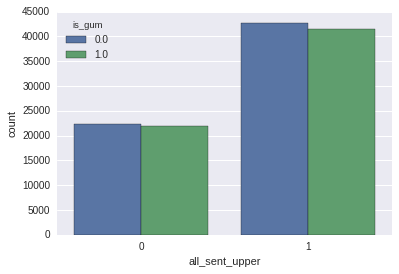

In [325]:
sns.countplot(x='all_sent_upper', hue='is_gum', data=comments)

### Punctuation count in comment

In [91]:
def punctuation_counts(comments, pattern='\(+', partion=True):
    if partion:
        return [sum(len(p) for p in re.findall(pattern, c)) / len(c) * 100 for c in comments]
    else:
        return [1 if len(re.findall(pattern, c)) > 0 else 0 for c in comments]

In [153]:
comments_list[:10]

['НАТЯНУЛИ МОСКВиЧЕЙ!!! ТЕПЕРЬ МОЖНО И ДОМОЙ ИХ ОТПРАВИТЬ 💪💪💪💪💪',
 'adddresssation не имеет значение где ЮР, ардрес то',
 'adddresssation где СК удобнее там и проводят а поближе подороже! Могу мск то сделать 650р',
 'Сегодня в 23:00 до 5:00 собираемся все НА АРЕНЕ и Валим там пока покрышки не сгорят... В ПРОТЕСТ СКУЧНЫМ И НУДНЫМ МУДАКАМ',
 'adddresssation пошлиб да проявили смелость там😉',
 'adddresssation любое ДТП есть страховой случай! И будет оплачиваться в законном порядке... А как в тебя въехали не ИМЕЕТ ЗНАЧЕНИЯ!',
 'adddresssation что если кого то что то неустраевает пойти и решить проблему, а не писать в типичный что под их окнами газуют...У ВСЕХ ГАЗУЮТ',
 'Норма у всех своя, а правила регулируют закон... А если так то действуй а не ори что у тебя проблема',
 'adddresssation да будет так',
 'Для особо одаренных есть ночные смены😀']

In [151]:
commas = punctuation_counts(comments_list, pattern='[\.]{2,}', partion=True)

In [158]:
punctuation_counts(['he... w...'], pattern='[\.]{2,}', partion=True)

[60.0]

In [159]:
commas[:10]

[0.0,
 0.0,
 0.0,
 2.479338842975207,
 0.0,
 2.307692307692308,
 2.142857142857143,
 3.0,
 0.0,
 0.0]

In [163]:
pd.Series(commas).value_counts()

0    107768
1     20742
dtype: int64

In [500]:
commas = np.reshape(commas, (-1, 1))

In [533]:
lr = lm.LogisticRegression()

In [503]:
lr = ensemble.RandomForestClassifier(10)

In [504]:
baseline_scores = cross_val_score(lr, commas, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

0.505563769356 0.0


In [628]:
comments['commas'] = commas

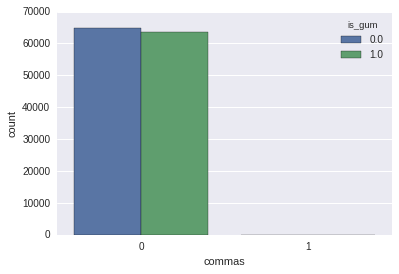

In [629]:
sns.countplot(x='commas', hue='is_gum', data=comments)

### Mean word length

In [92]:
def mean_word_length(comments):
    lengths = []
    for comment in comments:
        comment = comment.lower()
        comment = re.sub('[^а-яё\-]', ' ', comment).split()
        ls = [len(w) for w in comment]
        if len(ls):
            lengths.append(sum(ls) / len(ls))
        else:
            lengths.append(1)
    return lengths

In [526]:
comments_list[35:40]

['Все вопросы к администратору магазина! Незнания порядка не дает права вам нарушать его а жалобу можно отдать как администратору так и директору или есть такая КНИГА ЖАЛОБ',
 'Сука 100 р по везету и Вы в любом конце',
 'Папа новые даст не переживай😀',
 'Это чисто две банды долбоебов как от факела так и от динамо',
 'Сердце Егора ухнуло в пятки.']

In [530]:
mean_length = mean_word_length(comments_list)
mean_length[35:40]

[5.296296296296297, 3.0, 4.8, 4.0, 4.6]

In [531]:
mean_length = np.reshape(mean_length, (-1, 1))

In [534]:
baseline_scores = cross_val_score(lr, mean_length, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

0.520029569683 0.0124683358375


### Caps WORD

In [93]:
def caps_words(comments, partion=True):
    caps = []
    for comment in comments:
        count = len(re.findall('[А-ЯЁA-Z\-]{4,}', comment))
        total = len(comment.split())
        if partion and total != 0:
            caps.append(count / total * 100)
        else:
            caps.append(1 if count > 0 else 0)
    return caps

In [94]:
caps = caps_words(comments_list, False)

In [143]:
comments_list[:10]

['НАТЯНУЛИ МОСКВиЧЕЙ!!! ТЕПЕРЬ МОЖНО И ДОМОЙ ИХ ОТПРАВИТЬ 💪💪💪💪💪',
 'adddresssation не имеет значение где ЮР, ардрес то',
 'adddresssation где СК удобнее там и проводят а поближе подороже! Могу мск то сделать 650р',
 'Сегодня в 23:00 до 5:00 собираемся все НА АРЕНЕ и Валим там пока покрышки не сгорят... В ПРОТЕСТ СКУЧНЫМ И НУДНЫМ МУДАКАМ',
 'adddresssation пошлиб да проявили смелость там😉',
 'adddresssation любое ДТП есть страховой случай! И будет оплачиваться в законном порядке... А как в тебя въехали не ИМЕЕТ ЗНАЧЕНИЯ!',
 'adddresssation что если кого то что то неустраевает пойти и решить проблему, а не писать в типичный что под их окнами газуют...У ВСЕХ ГАЗУЮТ',
 'Норма у всех своя, а правила регулируют закон... А если так то действуй а не ори что у тебя проблема',
 'adddresssation да будет так',
 'Для особо одаренных есть ночные смены😀']

In [144]:
caps[:10]

[1, 0, 0, 1, 0, 1, 1, 0, 0, 0]

In [145]:
pd.Series(caps).value_counts()

0    124626
1      3884
dtype: int64

In [83]:
caps = np.reshape(caps, (-1, 1))

In [587]:
baseline_scores = cross_val_score(lr, caps, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

0.505563769356 0.0


### English words

In [95]:
def eng_words(comments, partion=True):
    engs = []
    for comment in comments:
        count = len([w for w in re.findall('[a-z\-]{3,}', comment, flags=re.IGNORECASE) if w != 'adddresssation'])
        total = len(comment.split())
        if partion and total != 0:
            engs.append(count / total * 100)
        else:
            engs.append(1 if count > 0 else 0)
    return engs

In [96]:
engs = eng_words(comments_list, False)

In [103]:
pd.Series(engs).value_counts()

0    110549
1      1621
dtype: int64

In [617]:
engs = np.reshape(engs, (-1, 1))

In [619]:
lr = lm.LogisticRegression()

In [623]:
baseline_scores = cross_val_score(lr, engs, y, cv=10)
print(baseline_scores.mean(), baseline_scores.stdt())

0.505563769356 0.0


### All comments features together

In [117]:
def get_comments_features(coms):
    features = pd.DataFrame()
    features['with_emoji'] = with_emoji(coms)
    big_letter, sents_count = sentence_stat(coms)
    features['big_letter'] = big_letter
    features['sents_count'] = sents_count
    features['punct_)'] = punctuation_counts(coms, pattern='\)+')
    features['punct_('] = punctuation_counts(coms, pattern='\)+', partion=False)
    features['punct_...'] = punctuation_counts(coms, pattern='\.\.\.', partion=False)
    features['punct_?'] = punctuation_counts(coms, pattern='\?+')
    features['punct_!'] = punctuation_counts(coms, pattern='\!+')
    features['punct_..'] = punctuation_counts(coms, pattern='[\.]{2,}')
    features['punct_1-9'] = punctuation_counts(coms, pattern='[0-9]{1,}')
    features['punct_"'] = punctuation_counts(coms, pattern='".+"')
    features['eng_words'] = eng_words(coms, True)
    features['mean_word_len'] = mean_word_length(coms)
    features['caps'] = caps_words(coms, True)
    features['em_proportion_rep'] = comments['em_proportion_rep'].values
    features['em_proportion_no_rep'] = comments['em_proportion_no_rep'].values
    features['adj_proportion'] = adj_proportion
    features['abc_proportion'] = comments['abc_proportion'].values
    return features

In [118]:
comment_features = get_comments_features(comments_list)

In [119]:
comment_features.describe()

,with_emoji,big_letter,sents_count,punct_),punct_(,punct_...,punct_?,punct_!,punct_..,punct_1-9,"punct_""",eng_words,mean_word_len,caps,em_proportion_rep,em_proportion_no_rep,adj_proportion,abc_proportion
count,111920.000000,111920.000000,111920.000000,111920.000000,111920.000000,111920.000000,111920.000000,111920.000000,111920.000000,111920.000000,111920.000000,111920.000000,111920.000000,111920.000000,111920.000000,111920.000000,111920.000000,111920.000000
mean,0.086338,0.669496,1.786883,0.894920,0.249526,0.143594,0.434935,0.410500,0.847868,0.529970,1.414752,0.247800,4.728073,0.432386,0.002809,0.002046,0.095708,0.837441
std,0.280864,0.470397,1.180639,2.277676,0.432741,0.350679,1.205713,1.583827,2.349302,2.190868,7.945333,2.889386,0.958400,3.795540,0.013078,0.008317,0.096743,0.112521
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.400000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.125000,0.000000,0.000000,0.000000,0.000000,0.755102
50%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.666667,0.000000,0.000000,0.000000,0.086957,0.858108
75%,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.272727,0.000000,0.000000,0.000000,0.153846,0.933333
max,1.000000,1.000000,21.000000,53.061224,1.000000,1.000000,53.448276,38.775510,44.660194,45.833333,100.000000,110.000000,20.571429,120.000000,0.250000,0.250000,1.000000,1.000000


In [120]:
word_char_features.shape, comment_features.shape # meta_features.shape

((111920, 2000), (111920, 18))

In [121]:
X = np.hstack((word_char_features.toarray(), comment_features.values))

In [122]:
X.shape

(111920, 2018)

In [130]:
y = comments.is_gum.values

In [112]:
lr = lm.LogisticRegression()

In [165]:
lr = naive_bayes.MultinomialNB()

In [124]:
lr = ensemble.RandomForestClassifier(20, min_samples_leaf=3, max_features=0.8, n_jobs=-1)

In [189]:
lr = ensemble.GradientBoostingClassifier()

In [190]:
np.random.seed(0)

In [97]:
baseline_scores = cross_val_score(lr, X, y, cv=3)
print(baseline_scores.mean(), baseline_scores.std())

0.521181838852 0.0138376103516


## Testing on human

In [106]:
from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit

In [107]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

In [138]:
s = StratifiedShuffleSplit(y, n_iter=1, test_size=20, random_state=0)

In [139]:
index_test = []

In [140]:
for train, test in s:
    index_test = test
    X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]

In [141]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [152]:
prediction = lr.predict_proba(X_test)[:, 1]

In [143]:
accuracy_score(y_test, prediction)

0.34999999999999998

In [144]:
ans = []
for comment in comments_list[index_test]:
    a = input(comment)
    ans.append(int(a))

Так у них же пллан какой то есть, типа стоять на всех главных перекрестках0
Только ковры на стены вешать, иначе слышно все1
adddresssation о, спасибо чувак, и тебе зачёт великий! Хоть кто-то знает, насколько клёвая штука - осциллограф!0
adddresssation Даже сапер имеет право на ошибку...Так вот...Я не он1
adddresssation я не говорила что нет обработки. фотошоп исправляет недостатки, а здесь просто улучшено качество самой фотографии.1
adddresssation мне не нужен допинг чтобы источать радость и хорошее настроение ☺1
adddresssation ну это да. было бы желание.0
adddresssation Вы имели ввиду "никто не шутит"0
adddresssation Самвел армянское имя и к Махачкалинской области РФ(Дагестану) никакого отношения не имеет1
В 6 движуха уже во всю0
adddresssation Замена заявленного кондидата в олимпийских игр происходит как минимум за 3 дня и то по травме))1
Посмотреть что ли в окно0
adddresssation согласна, некоторые дети бросают своих стариков 😔1
Пересматриваю все части, чтобы пойти на 7ю подготовленн

In [145]:
sum(ans)

12

In [146]:
len(ans)

20

In [147]:
accuracy_score(y_test, ans)

0.69999999999999996

In [150]:
y_test = [int(y) for y in y_test]
prediction = [int(p) for p in prediction]

In [153]:
list(zip(comments_list[index_test], y_test, prediction, ans))

[('Так у них же пллан какой то есть, типа стоять на всех главных перекрестках',
  0,
  0.51186352495835707,
  0),
 ('Только ковры на стены вешать, иначе слышно все', 0, 0.51120625719204627, 1),
 ('adddresssation о, спасибо чувак, и тебе зачёт великий! Хоть кто-то знает, насколько клёвая штука - осциллограф!',
  0,
  0.37807061591042296,
  0),
 ('adddresssation Даже сапер имеет право на ошибку...Так вот...Я не он',
  1,
  0.54625583923717969,
  1),
 ('adddresssation я не говорила что нет обработки. фотошоп исправляет недостатки, а здесь просто улучшено качество самой фотографии.',
  1,
  0.42449077280158115,
  1),
 ('adddresssation мне не нужен допинг чтобы источать радость и хорошее настроение ☺',
  1,
  0.45122448038554991,
  1),
 ('adddresssation ну это да. было бы желание.', 1, 0.61851027790870372, 0),
 ('adddresssation Вы имели ввиду "никто не шутит"', 0, 0.52869545175277877, 0),
 ('adddresssation Самвел армянское имя и к Махачкалинской области РФ(Дагестану) никакого отношения не и